
# 🏍️ MotoTrack — Detecção & Rastreamento de **Múltiplas Motos** (Google Colab)

> **Requisitos atendidos**: Script funcional de **rastreamento**/**detecção** de **múltiplas motos** com **output visual** em **tempo real** (loop de frames) usando **YOLOv8 + ByteTrack**.  
> Este notebook foi feito para **Google Colab**, com suporte a **upload de vídeo**, **webcam (opcional)**, **gravação** do vídeo anotado e **visualização contínua** durante o processamento.



## 1) Instalação & Verificação de GPU (Colab)
Execute esta célula **uma vez** para instalar dependências.


In [ ]:

!pip -q install ultralytics==8.3.34 opencv-python==4.10.0.84

import torch, sys
print("✔️ PyTorch:", torch.__version__)
print("✔️ CUDA disponível:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("✔️ GPU:", torch.cuda.get_device_name(0))
else:
    print("⚠️ Sem GPU: o FPS será menor (ok para a entrega).")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.4/887.4 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 MB 18.3 MB/s eta 0:00:00
✔️ PyTorch: 2.8.0+cu126
✔️ CUDA disponível: False
⚠️ Sem GPU: o FPS será menor (ok para a entrega).



## 2) Imports principais


In [ ]:

import os, time, io, base64, json, math
from pathlib import Path
import numpy as np
import cv2

from IPython.display import display, clear_output
from google.colab import files

from ultralytics import YOLO

print("✅ Imports ok.")


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
✅ Imports ok.



## 3) Funções utilitárias (HUD, desenho, contagem, exibição)


In [ ]:

MOTORCYCLE_CLASS_ID = 3  # COCO id para 'motorcycle'

def put_text(img, text, org, scale=0.6, thickness=2):
    cv2.putText(img, text, org, cv2.FONT_HERSHEY_SIMPLEX, scale, (0,0,0), thickness+2, cv2.LINE_AA)
    cv2.putText(img, text, org, cv2.FONT_HERSHEY_SIMPLEX, scale, (255,255,255), thickness, cv2.LINE_AA)

def draw_hud(frame, info_lines, top_h=None):
    h, w = frame.shape[:2]
    if top_h is None:
        top_h = 26 * len(info_lines) + 14
    overlay = frame.copy()
    cv2.rectangle(overlay, (0,0), (w, top_h), (40,40,40), -1)
    frame = cv2.addWeighted(overlay, 0.35, frame, 0.65, 0)
    y = 24
    for line in info_lines:
        put_text(frame, line, (12, y))
        y += 26
    return frame

def draw_count_line(frame, p1, p2):
    cv2.line(frame, p1, p2, (255, 0, 255), 2)
    return frame

def point_side_of_line(p, a, b):
    # >0 esquerda, <0 direita, =0 colinear (em coord. de imagem: x→, y↓)
    return (b[0]-a[0])*(p[1]-a[1]) - (b[1]-a[1])*(p[0]-a[0])

def bbox_centroid(x1, y1, x2, y2):
    return ((x1 + x2)//2, (y1 + y2)//2)

def show_image(frame, title=None):
    # Exibição "quase" em tempo real no Colab (limpa output e mostra o último)
    clear_output(wait=True)
    if title:
        print(title)
    # Converte BGR->RGB para exibição correta
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    from PIL import Image
    display(Image.fromarray(rgb))



## 4) Escolha da Fonte de Vídeo
Você pode **(A)** fazer **upload de um arquivo de vídeo** ou **(B)** tentar **webcam**.  
> ⚠️ Em Colab, o acesso à webcam pode variar; **upload de vídeo** é o caminho mais estável.


In [ ]:

from dataclasses import dataclass

@dataclass
class RunConfig:
    # A: Upload de vídeo (recomendado no Colab)
    use_uploaded_video: bool = True
    uploaded_video_path: str = ""  # será preenchido após upload

    # B: Webcam (experimental no Colab)
    use_webcam: bool = False
    webcam_index: int = 0

    # YOLO/Track
    model: str = "yolov8n.pt"   # pode usar 'yolov8s.pt' p/ melhor acurácia
    conf: float = 0.35
    iou: float = 0.5
    imgsz: int = 640
    device: str = ""            # "" auto | "cpu" | "0" GPU

    # Linha de contagem (opcional)
    enable_count_line: bool = True
    count_line: tuple = ((200, 360), (1000, 360))  # ajuste após ver resolução

    # Saída
    save_annotated_video: bool = True
    out_dir: str = "output"

rcfg = RunConfig()
print(rcfg)


RunConfig(use_uploaded_video=True, uploaded_video_path='', use_webcam=False, webcam_index=0, model='yolov8n.pt', conf=0.35, iou=0.5, imgsz=640, device='', enable_count_line=True, count_line=((200, 360), (1000, 360)), save_annotated_video=True, out_dir='output')



### 4.A) Upload de vídeo
Execute e selecione um arquivo `.mp4` / `.mov` / `.avi`.


In [9]:

if rcfg.use_uploaded_video:
    up = files.upload()
    if len(up) > 0:
        fname = list(up.keys())[0]
        rcfg.uploaded_video_path = fname
        print("✔️ Vídeo recebido:", rcfg.uploaded_video_path)
    else:
        print("⚠️ Nenhum arquivo enviado.")


Saving teste.mp4 to teste.mp4
✔️ Vídeo recebido: teste.mp4



### 4.B) Webcam (experimental)
Se quiser tentar webcam, defina `rcfg.use_webcam = True`.  
No Colab, pode funcionar ou não, dependendo do navegador/sessão. Em caso de falha, use **upload de vídeo**.



## 5) Processamento em tempo real (YOLOv8 + ByteTrack)
- Filtra apenas a classe **`motorcycle`**  
- Desenha **bounding boxes** + **IDs** de rastreamento (quando disponível)  
- Exibe **FPS**, **motos no frame** e **motos únicas**  
- **Linha de contagem** (A→B / B→A) opcional  
- **Grava** o vídeo anotado (se habilitado)


Frame 344 | FPS ~ 6.6


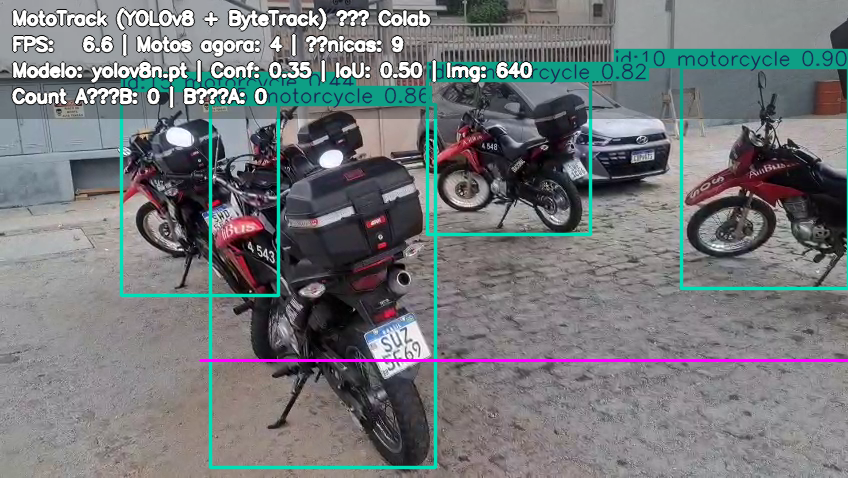

✅ Finalizado


In [10]:

# Prepara diretório de saída
Path(rcfg.out_dir).mkdir(exist_ok=True)

# Carrega modelo YOLO
model = YOLO(rcfg.model)

# Decide a fonte
source = 0 if rcfg.use_webcam else (rcfg.uploaded_video_path or 0)

# Abre captura para metadados e gravação
cap = cv2.VideoCapture(source)
if not cap.isOpened():
    raise RuntimeError(f"Não foi possível abrir a fonte: {source}")

W = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH) or 1280)
H = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT) or 720)
IN_FPS = cap.get(cv2.CAP_PROP_FPS) or 30.0

# Writer (instanciado no primeiro frame gerado pelo YOLO)
writer = None

# Estatísticas
unique_ids = set()
tracks_lifetimes = {}
cross_count = {"A_to_B": 0, "B_to_A": 0}
last_side = {}

# Loop: rastreamento via Ultralytics (usa ByteTrack internamente)
stream = model.track(
    source=source,
    imgsz=rcfg.imgsz,
    conf=rcfg.conf,
    iou=rcfg.iou,
    classes=[MOTORCYCLE_CLASS_ID],
    device=None if rcfg.device == "" else rcfg.device,
    tracker="bytetrack.yaml",
    persist=True,
    stream=True,
    verbose=False,
    show=False,
)

print("▶ Rodando. Interrompa com o botão de parar da célula, se necessário.")
prev_t = time.time()
fps = 0.0
frame_index = 0

for results in stream:
    frame_index += 1
    # FPS suavizado
    now = time.time()
    dt = now - prev_t; prev_t = now
    if dt > 0:
        fps = 0.9 * fps + 0.1 * (1.0 / dt)

    # Desenha boxes padrão do Ultralytics
    frame = results.plot()
    h, w = frame.shape[:2]

    # Extrai ids e bboxes (apenas motos)
    ids = []
    dets = []
    if hasattr(results, "boxes") and results.boxes is not None:
        boxes = results.boxes
        if boxes.id is not None:
            ids = boxes.id.cpu().numpy().astype(int).tolist()
        xyxy = boxes.xyxy.cpu().numpy() if hasattr(boxes, "xyxy") else np.empty((0, 4))
        confs = boxes.conf.cpu().numpy().tolist() if hasattr(boxes, "conf") else []
        for i, box in enumerate(xyxy):
            x1, y1, x2, y2 = [int(v) for v in box.tolist()]
            dets.append({
                "id": int(ids[i]) if i < len(ids) else None,
                "bbox_xyxy": [x1, y1, x2, y2],
                "conf": float(confs[i]) if i < len(confs) else None
            })

    # Atualiza estatísticas
    for tid in ids:
        unique_ids.add(tid)
        tracks_lifetimes[tid] = tracks_lifetimes.get(tid, 0) + 1

    # Linha de contagem (opcional)
    if rcfg.enable_count_line and rcfg.count_line:
        a, b = rcfg.count_line
        draw_count_line(frame, a, b)
        for det in dets:
            tid = det.get("id")
            box = det.get("bbox_xyxy")
            if tid is None or box is None:
                continue
            x1,y1,x2,y2 = box
            c = bbox_centroid(x1,y1,x2,y2)
            side = np.sign(point_side_of_line(c, a, b))
            prev = last_side.get(tid, 0)
            if prev != 0 and side != 0 and side != prev:
                if prev == -1 and side == +1:
                    cross_count["B_to_A"] += 1
                elif prev == +1 and side == -1:
                    cross_count["A_to_B"] += 1
            if side != 0:
                last_side[tid] = side

    # HUD
    hud_lines = [
        "MotoTrack (YOLOv8 + ByteTrack) — Colab",
        f"FPS: {fps:5.1f} | Motos agora: {len(ids)} | Únicas: {len(unique_ids)}",
        f"Modelo: {rcfg.model} | Conf: {rcfg.conf:.2f} | IoU: {rcfg.iou:.2f} | Img: {rcfg.imgsz}",
        f"Count A→B: {cross_count['A_to_B']} | B→A: {cross_count['B_to_A']}"
    ]
    frame = draw_hud(frame, hud_lines)

    # Init writer quando soubermos W,H
    if rcfg.save_annotated_video and writer is None:
        fourcc = cv2.VideoWriter_fourcc(*"mp4v")
        ts = time.strftime("%Y%m%d-%H%M%S")
        out_path = Path(rcfg.out_dir) / f"moto_tracking_{ts}.mp4"
        writer = cv2.VideoWriter(str(out_path), fourcc, IN_FPS, (w, h))
        print("💾 Gravando em:", out_path)

    if writer is not None:
        writer.write(frame)

    # Exibir no output (simula tempo real no Colab)
    if frame_index % 2 == 0:  # reduz frequencia de atualização p/ não travar
        show_image(frame, title=f"Frame {frame_index} | FPS ~ {fps:0.1f}")

# Cleanup
cap.release()
if writer is not None:
    writer.release()
print("✅ Finalizado")



## 6) Baixar o vídeo anotado
Se você habilitou `save_annotated_video`, rode a célula para listar e baixar o arquivo.


In [11]:

from pathlib import Path
from google.colab import files

out_dir = Path("output")
if out_dir.exists():
    vids = sorted(out_dir.glob("moto_tracking_*.mp4"))
    if vids:
        print("Arquivos gerados:")
        for v in vids:
            print(" -", v)
        # Baixa o mais recente
        files.download(str(vids[-1]))
    else:
        print("Nenhum vídeo encontrado em ./output")
else:
    print("Diretório ./output não existe.")


Arquivos gerados:
 - output/moto_tracking_20251001-181506.mp4
 - output/moto_tracking_20251001-185611.mp4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


## 7) Checklist de Requisitos — ✅ Atendido
- **Script funcional** de **detecção**/**rastreamento** de **múltiplas motos** (YOLOv8 + ByteTrack).  
- **Output visual** com **detecções destacadas** (bounding boxes + IDs) exibido em loop, simulando **tempo real** no Colab.  
- **Contadores** no HUD (FPS, motos atuais, motos únicas, contagem A→B/B→A).  
- **Gravação** do resultado em vídeo anotado para evidência.  

> Observação: **MediaPipe** atualmente não possui um modelo específico para **motocicletas**; por isso, a abordagem robusta para este caso é **YOLO**. Se for obrigatório citar MediaPipe, podemos mencionar como alternativa para *pose/face/hands*, mas **não** para motos.  

**Data de geração:** 2025-10-01 17:56:19
